In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from sklearn.linear_model import Lasso
except Exception:
    Lasso = None
from pybaselines import Baseline
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["axes.grid"] = True


In [2]:
from scipy.signal import butter, filtfilt, decimate
def list_doric_channels(path):
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]
        chans = []
        if "LockInAOUT02" in base:
            for k in base["LockInAOUT02"].keys():
                if k.startswith("AIN"):
                    chans.append(k)
        chans = sorted(chans)

        digital = []
        if "DigitalIO" in base:
            for k in base["DigitalIO"].keys():
                if k.startswith("DIO"):
                    digital.append(k)
        return chans, digital

def load_doric(path, channel="AIN01", signal_folder="LockInAOUT02", ref_folder="LockInAOUT01",
              trigger_name=None):
    """
    Returns dict with:
      time, sig465, ref405, fs, (optional) trig_time, trig
    """
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]

        sig = np.asarray(base[signal_folder][channel][()], float)
        ref = np.asarray(base[ref_folder][channel][()], float)

        # time: prefer the matching folder time if size matches
        t_sig = np.asarray(base[signal_folder]["Time"][()], float) if "Time" in base[signal_folder] else np.array([])
        t_ref = np.asarray(base[ref_folder]["Time"][()], float) if "Time" in base[ref_folder] else np.array([])

        if t_sig.size == sig.size:
            t = t_sig
        elif t_ref.size == sig.size:
            t = t_ref
        else:
            # fallback
            dt = np.nanmedian(np.diff(t_sig)) if t_sig.size > 2 else 1/1000
            t = np.arange(sig.size) * dt

        # if ref length differs, interpolate onto t if possible
        if ref.size != sig.size:
            if t_ref.size == ref.size:
                ref = np.interp(t, t_ref, ref)
            else:
                ref = np.resize(ref, sig.size)

        # sampling rate
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan

        # optional digital trigger overlay
        trig_time = None
        trig = None
        if trigger_name:
            if "DigitalIO" in base and trigger_name in base["DigitalIO"]:
                dio = base["DigitalIO"]
                trig = np.asarray(dio[trigger_name][()], float)
                trig_time = np.asarray(dio["Time"][()], float) if "Time" in dio else None

                # if lengths mismatch, interpolate signals to trigger time (like your Doric logic)
                if trig_time is not None and trig_time.size and trig_time.size != t.size:
                    sig = np.interp(trig_time, t, sig)
                    ref = np.interp(trig_time, t, ref)
                    t = trig_time
                    fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else fs

    out = {"time": t, "sig465": sig, "ref405": ref, "fs": fs}
    if trig is not None and trig_time is not None:
        out["trig_time"] = trig_time
        out["trig"] = trig
    return out
import numpy as np

def ols_fit(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if np.sum(m) < 10:
        return 1.0, 0.0
    X = np.vstack([x[m], np.ones(np.sum(m))]).T
    coef, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    return float(coef[0]), float(coef[1])
def preprocess_signal(sig, fs_raw, target_fs=100, lpf_cutoff=3):
    """
    1\) Low-pass filter (Butterworth, lpf_cutoff Hz)
    2\) Decimate to target sampling rate (target_fs Hz)
    """
    nyquist = 0.5 * fs_raw
    normal_cutoff = lpf_cutoff / nyquist
    b, a = butter(N=2, Wn=normal_cutoff, btype="low", analog=False)
    sig_filtered = filtfilt(b, a, sig)

    q = int(fs_raw / target_fs)
    if q > 1:
        sig_downsampled = decimate(sig_filtered, q)
        real_fs = fs_raw / q
    else:
        sig_downsampled = sig_filtered
        real_fs = fs_raw

    return sig_downsampled, real_fs


def compute_arpls_baselines(
    baseline_fitter,
    sig_f,
    ref_f,
    lam=1e9,
    diff_order=2,
    max_iter=50,
    tol=1e-3,
):
    """
    Compute arPLS baselines for signal and reference.

    Parameters:
        baseline_fitter: pybaselines.Baseline instance, already set up with x_data.
        sig_f: 1D array-like, preprocessed signal channel.
        ref_f: 1D array-like, preprocessed reference channel.
        lam: smoothing parameter.
        diff_order: difference order for the penalty.
        max_iter: maximum iterations for arPLS.
        tol: convergence tolerance.

    Returns:
        b_sig_arpls, b_ref_arpls
    """
    b_sig_arpls, _ = baseline_fitter.arpls(
        sig_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    b_ref_arpls, _ = baseline_fitter.arpls(
        ref_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    return b_sig_arpls, b_ref_arpls




def compute_motion_corrected_dff(sig_f, ref_f, b_sig, b_ref):
    """
    Computes motion-corrected dF/F using the 'Standardized' method:
    1) Calculate dF/F for both signal and reference channels separately.
       dff_sig_raw = (sig - b_sig) / b_sig
       dff_ref_raw = (ref - b_ref) / b_ref
    2) Fit dff_ref_raw to dff_sig_raw using OLS (y = ax + b).
    3) Subtract the fitted reference from the signal dF/F.
       dff_mc = dff_sig_raw - (a * dff_ref_raw + b)
    """

    # --- 1. Calculate raw dF/F for each channel ---
    # Prepare denominators (avoid division by zero)
    den_sig = np.asarray(b_sig, float).copy()
    den_sig[np.abs(den_sig) < 1e-12] = np.nan

    den_ref = np.asarray(b_ref, float).copy()
    den_ref[np.abs(den_ref) < 1e-12] = np.nan

    # Calculate standard dF/F (percent change) for each
    dff_sig_raw = (sig_f - b_sig) / den_sig
    dff_ref_raw = (ref_f - b_ref) / den_ref

    # --- 2. Fit Reference dF/F to Signal dF/F ---
    # We fit: dff_sig_raw ~ a * dff_ref_raw + b
    a, b = ols_fit(dff_ref_raw, dff_sig_raw)

    # --- 3. Subtract to get Motion-Corrected dF/F ---
    # The fitted reference represents the motion/artifact component in dF/F space
    fitted_ref = (a * dff_ref_raw + b)
    dff_mc = dff_sig_raw - fitted_ref

    # Return dictionary with keys compatible with your analysis pipeline
    # Note: 'sig_det' and 'ref_det' now refer to the raw dF/F traces
    return {
        "sig_det": dff_sig_raw,   # Now holds raw dF/F of signal
        "ref_det": dff_ref_raw,   # Now holds raw dF/F of reference
        "a": a,                   # Slope of the regression in dF/F space
        "b": b,                   # Intercept of the regression
        "delta_mc": dff_mc,       # The final motion-corrected dF/F
        "dff": dff_mc,            # Same as delta_mc (kept for compatibility)
    }
def list_doric_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".doric"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files
import numpy as np
import matplotlib.pyplot as plt

def qc_sig_ref_correlation(sig, ref, title="", max_points=8000, ax=None):
    """
    Scatter sig vs ref with OLS fit + Pearson R, R^2.
    Downsamples points for plotting but computes stats on full data.
    Returns dict with r, r2, slope, intercept, n.
    """
    sig = np.asarray(sig, float)
    ref = np.asarray(ref, float)

    m = np.isfinite(sig) & np.isfinite(ref)
    sig = sig[m]
    ref = ref[m]
    n = int(sig.size)

    out = {"r": np.nan, "r2": np.nan, "slope": np.nan, "intercept": np.nan, "n": n}

    if n < 10:
        return out

    # Pearson R
    s0 = sig - np.mean(sig)
    r0 = ref - np.mean(ref)
    denom = np.sqrt(np.sum(s0**2) * np.sum(r0**2))
    if denom > 0:
        r = float(np.sum(s0 * r0) / denom)
    else:
        r = np.nan
    out["r"] = r
    out["r2"] = float(r**2) if np.isfinite(r) else np.nan

    # OLS fit sig = a*ref + b
    X = np.vstack([ref, np.ones_like(ref)]).T
    coef, *_ = np.linalg.lstsq(X, sig, rcond=None)
    a, b = float(coef[0]), float(coef[1])
    out["slope"] = a
    out["intercept"] = b

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.2, 3.6))

    # downsample points for display
    if n > max_points:
        idx = np.random.default_rng(0).choice(n, size=max_points, replace=False)
        xs = ref[idx]
        ys = sig[idx]
    else:
        xs, ys = ref, sig

    ax.scatter(xs, ys, s=6, alpha=0.25, edgecolors="none")

    # fit line over displayed x-range
    xlo, xhi = np.nanpercentile(ref, [1, 99])
    xx = np.linspace(xlo, xhi, 200)
    yy = a * xx + b
    ax.plot(xx, yy, lw=1.8)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Reference 405 (a.u.)")
    ax.set_ylabel("Signal 465 (a.u.)")

    # cosmetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.15)

    ax.text(
        0.02, 0.98,
        f"R = {out['r']:.3f}\nR² = {out['r2']:.3f}\na = {a:.3g}",
        transform=ax.transAxes, va="top", ha="left", fontsize=9
    )

    return out


In [3]:
folder = r'C:\Analysis\fiber_photometry_app\test_data\lick_edited'
doric_paths = list_doric_files(folder)
print(doric_paths)

['C:\\Analysis\\fiber_photometry_app\\test_data\\lick_edited\\30545-lickedit.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\lick_edited\\30546-lickedit.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\lick_edited\\30547-lickedit.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\lick_edited\\30549-lickedit.doric']


Processing: 30545-lickedit.doric -> Animal ID: 30545


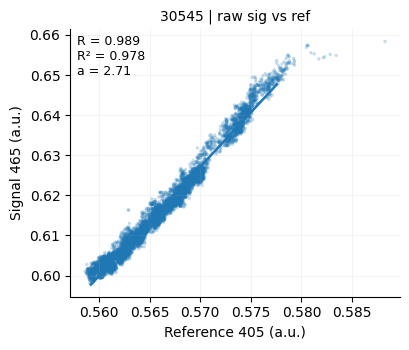

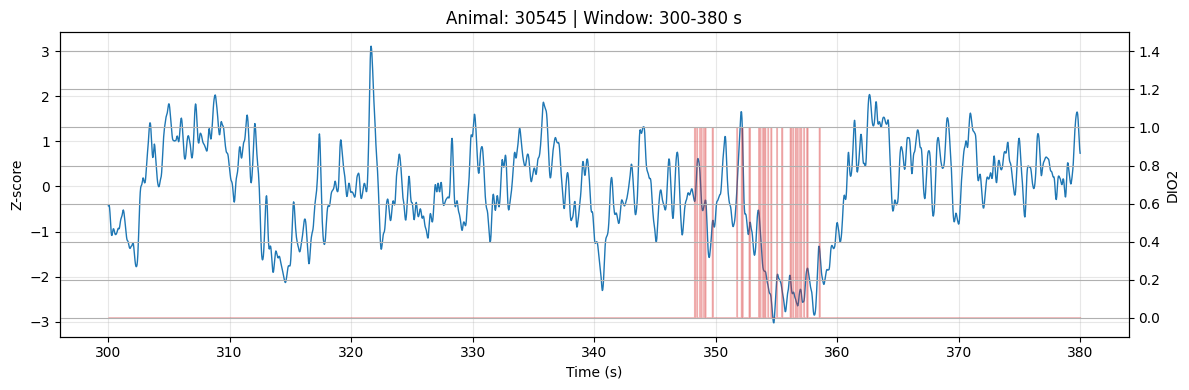

Processing: 30546-lickedit.doric -> Animal ID: 30546


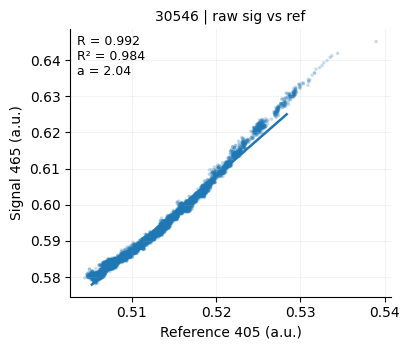

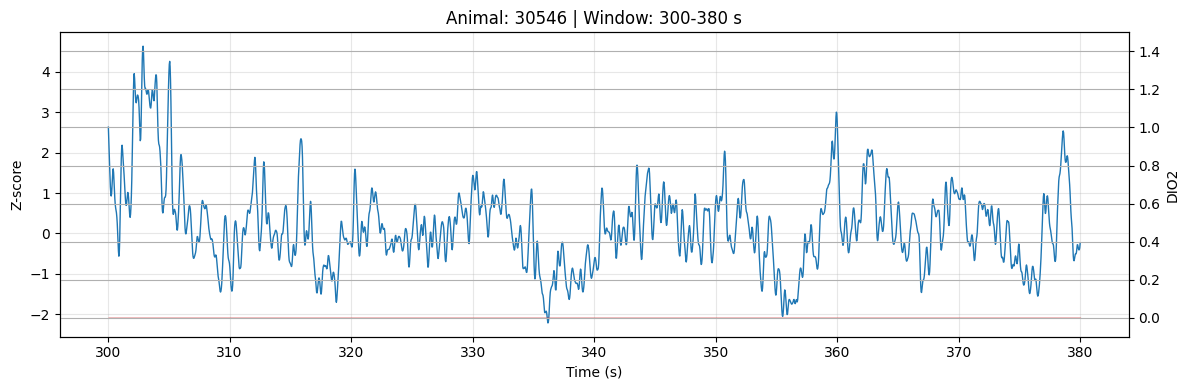

Processing: 30547-lickedit.doric -> Animal ID: 30547


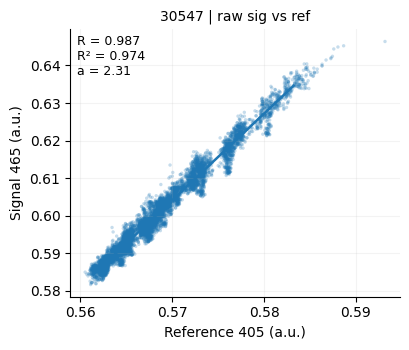

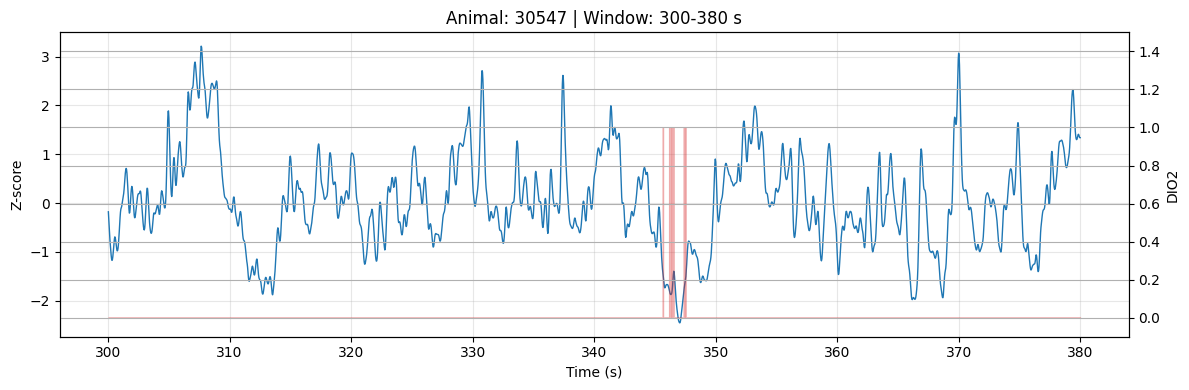

Processing: 30549-lickedit.doric -> Animal ID: 30549


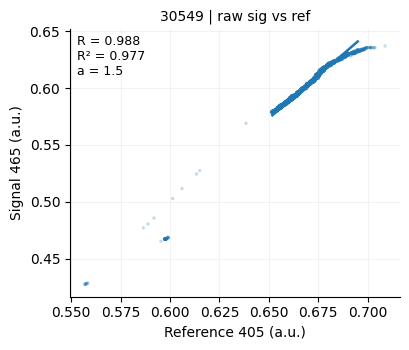

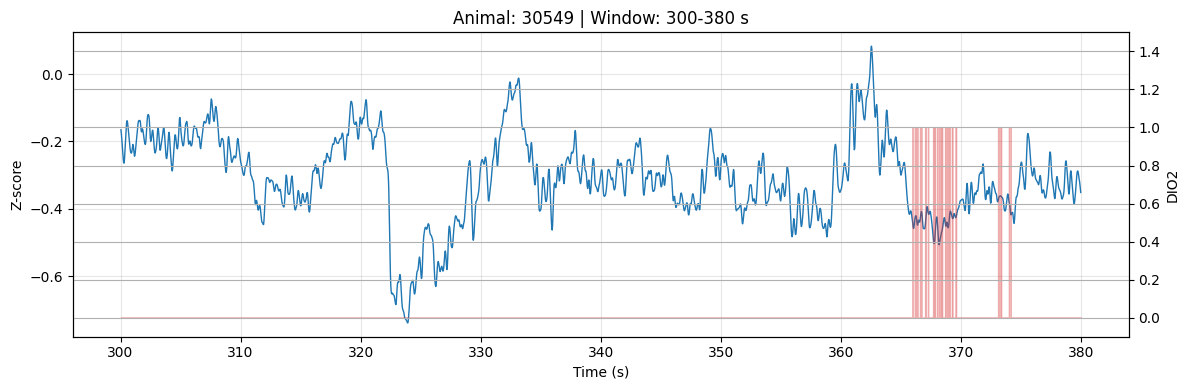

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

results = {}
qc_list = []

# Parameters
target_fs = 30
lpf_cutoff = 3
lam = 1e11
diff_order = 2
max_iter = 50
tol = 1e-3

plot_window = [300, 380]  # or None

def apply_plot_window(t: np.ndarray, *series: np.ndarray, plot_window=None):
    if plot_window is None:
        mask = np.ones_like(t, dtype=bool)
        return (t, *series, mask)

    lo, hi = float(plot_window[0]), float(plot_window[1])
    if lo > hi:
        lo, hi = hi, lo

    mask = (t >= lo) & (t <= hi)
    t2 = t[mask]
    series2 = [s[mask] if s is not None else None for s in series]
    return (t2, *series2, mask)

for path in doric_paths:
    filename = os.path.basename(path)

    if '-' in filename:
        animal_id = filename.split('-')[0]
    else:
        animal_id = os.path.splitext(filename)[0]

    print(f"Processing: {filename} -> Animal ID: {animal_id}")

    rec = load_doric(path, trigger_name="DIO02")

    sig = rec["sig465"]
    ref = rec["ref405"]
    fs  = rec["fs"]

    dio_raw  = rec.get("trig", None)
    dio_time = rec.get("trig_time", None)

    # -------------------- PURE QC: sig vs ref correlation (raw) --------------------
    fig_qc, ax_qc = plt.subplots(figsize=(4.2, 3.6))
    qc = qc_sig_ref_correlation(sig, ref, title=f"{animal_id} | raw sig vs ref", ax=ax_qc)
    plt.tight_layout()
    plt.show()

    # -------------------- Preprocess --------------------
    sig_f, fs_sig = preprocess_signal(sig, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)
    ref_f, fs_ref = preprocess_signal(ref, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)

    dt_ds = 1.0 / fs_sig
    t_ds = np.arange(sig_f.size) * dt_ds

    baseline_fitter = Baseline(x_data=t_ds)
    b_sig, b_ref = compute_arpls_baselines(
        baseline_fitter, sig_f, ref_f,
        lam=lam, diff_order=diff_order, max_iter=max_iter, tol=tol
    )

    dff_results = compute_motion_corrected_dff(sig_f, ref_f, b_sig, b_ref)
    dff_mc = dff_results["dff"]
    dff_z = (dff_mc - np.nanmean(dff_mc)) / np.nanstd(dff_mc)

    if dio_raw is not None and dio_time is not None:
        dio_ds = np.interp(t_ds, dio_time, dio_raw)
    else:
        dio_ds = np.zeros_like(t_ds)

    results[animal_id] = {
        "t": t_ds,
        "dff": dff_mc,
        "zscore": dff_z,
        "dio2": dio_ds,
        "qc_sig_ref": qc,            # <-- stored here
        "qc_sig_std": float(np.nanstd(sig)),
        "qc_ref_std": float(np.nanstd(ref)),
        "file": filename

    }

    qc_list.append({
        "animal": animal_id,
        "file": filename,
        "r": qc.get("r", np.nan),
        "r2": qc.get("r2", np.nan),
        "slope": qc.get("slope", np.nan),
        "intercept": qc.get("intercept", np.nan),
        "n": qc.get("n", 0),
        "sig_std": float(np.nanstd(sig)),
        "ref_std": float(np.nanstd(ref)),
    })

    # -------------------- Plot window --------------------
    t_plot, dff_z_plot, dio_plot, _mask = apply_plot_window(
        t_ds, dff_z, dio_ds, plot_window=plot_window
    )

    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Z-score")
    ax1.plot(t_plot, dff_z_plot, lw=1, label="dF/F Z-score")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.set_ylabel("DIO2")
    ax2.fill_between(t_plot, dio_plot, alpha=0.3, step="mid", label="DIO2", color='C3')
    ax2.set_ylim(-0.1, 1.5)

    if plot_window is not None:
        plt.title(f"Animal: {animal_id} | Window: {plot_window[0]}-{plot_window[1]} s")
    else:
        plt.title(f"Animal: {animal_id} | File: {filename}")

    plt.tight_layout()
    plt.show()


In [5]:
from typing import Tuple
from scipy.ndimage import gaussian_filter1d

def _compute_psth_matrix(
    t: np.ndarray,
    y: np.ndarray,
    event_times: np.ndarray,
    window: Tuple[float, float],
    baseline_win: Tuple[float, float],
    resample_hz: float,
    smooth_sigma_s: float = 0.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      tvec (relative time), mat (n_events x n_samples) with NaNs if missing
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    ev = np.asarray(event_times, float)
    ev = ev[np.isfinite(ev)]
    if ev.size == 0:
        return np.array([], float), np.zeros((0, 0), float)

    dt = 1.0 / float(resample_hz)
    tvec = np.arange(window[0], window[1] + 0.5 * dt, dt)

    mat = np.full((ev.size, tvec.size), np.nan, float)

    for i, et in enumerate(ev):
        # baseline
        bmask = (t >= et + baseline_win[0]) & (t <= et + baseline_win[1])
        base = y[bmask]
        if base.size < 5 or not np.any(np.isfinite(base)):
            continue
        bmean = np.nanmean(base)
        bstd = np.nanstd(base)
        if not np.isfinite(bstd) or bstd <= 1e-12:
            bstd = 1.0

        # extract window and interpolate onto tvec
        wmask = (t >= et + window[0]) & (t <= et + window[1])
        tw = t[wmask] - et
        yw = y[wmask]
        good = np.isfinite(tw) & np.isfinite(yw)
        if np.sum(good) < 5:
            continue
        # sparse interpolation
        mat[i, :] = np.interp(tvec, tw[good], (yw[good] - bmean) / bstd)

    if smooth_sigma_s and smooth_sigma_s > 0:
        # simple gaussian smoothing along time axis
        sigma = smooth_sigma_s * resample_hz
        mat = gaussian_filter1d(mat, sigma=sigma, axis=1, mode="nearest")

    return tvec, mat




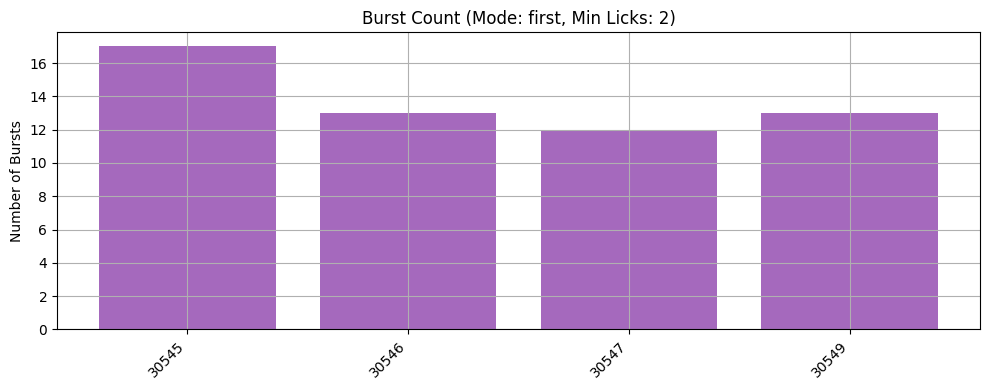

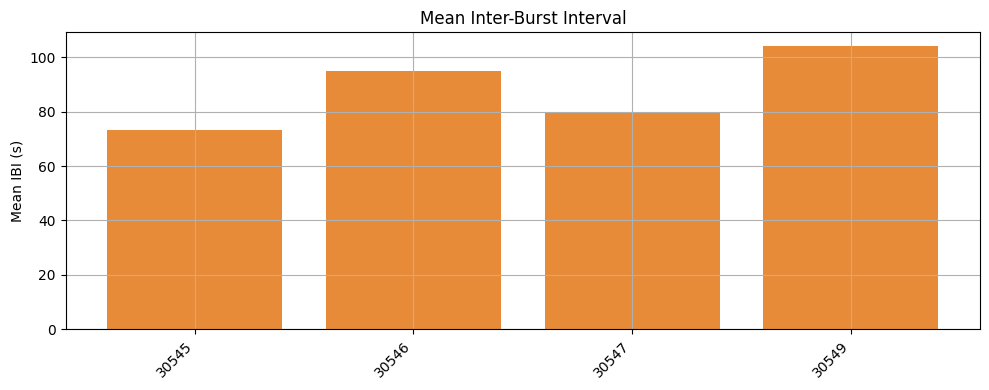

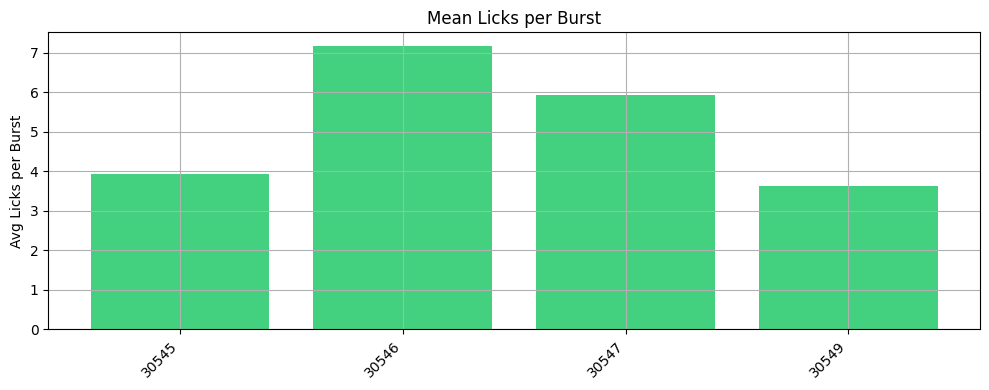

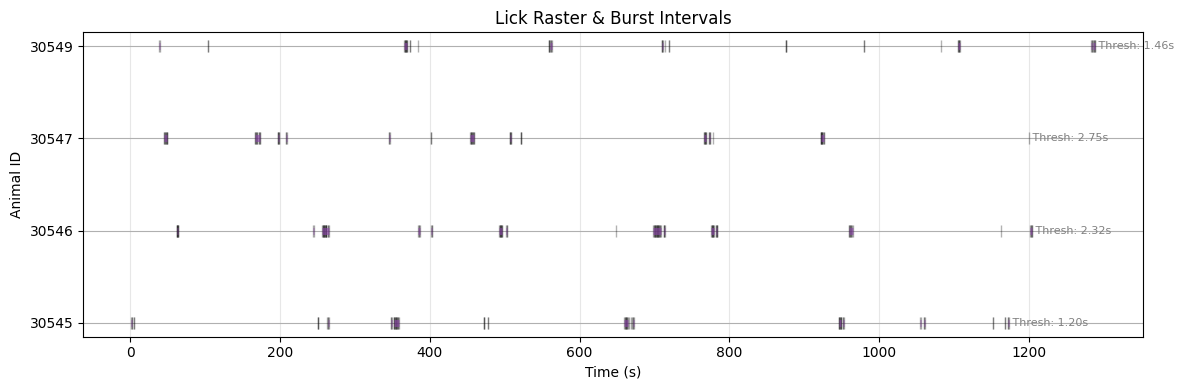

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- User Options ----
PLOT_WINDOW = None          # [start_s, end_s] or None for full session
DIO_THRESHOLD = 0.5         # Voltage threshold for digital IO
MIN_EVENT_GAP_S = 0.2      # Debounce: ignore events closer than 20ms
BOUT_GAP_S = "auto"         # New burst if IEI > this (seconds). "auto" uses log-KMeans.
MIN_LICKS_PER_BURST = 2     # Minimum licks to count as a valid burst

# Burst Alignment Mode for 'burst_t':
# "first"  : Aligns to the very first lick
# "second" : Aligns to the second lick
BURST_EVENT_MODE = "first"

def apply_window(t: np.ndarray, *series: np.ndarray, plot_window=None):
    """Restricts time and data arrays to a specific time window."""
    if plot_window is None:
        mask = np.ones_like(t, dtype=bool)
        return (t, *series, mask)

    lo, hi = float(plot_window[0]), float(plot_window[1])
    if lo > hi: lo, hi = hi, lo

    mask = (t >= lo) & (t <= hi)
    t_masked = t[mask]
    series_masked = [s[mask] if s is not None else None for s in series]
    return (t_masked, *series_masked, mask)

def detect_lick_times(t: np.ndarray, dio: np.ndarray, threshold=0.5, min_event_gap_s=0.02):
    """Converts raw analog DIO signal into discrete timestamps with debouncing."""
    t = np.asarray(t, float)
    x = np.asarray(dio, float)
    if t.size == 0 or x.size == 0:
        return np.array([], dtype=float)

    binary = x >= float(threshold)
    rising_indices = np.flatnonzero(np.diff(binary.astype(np.int8), prepend=binary[0].astype(np.int8)) == 1)
    lick_t = t[rising_indices].astype(float)

    if lick_t.size <= 1:
        return lick_t

    # Debounce
    dt = np.diff(lick_t)
    keep = np.ones_like(lick_t, dtype=bool)
    keep[1:] = dt >= float(min_event_gap_s)

    return lick_t[keep]

def get_burst_threshold(lick_t: np.ndarray, bout_gap_s="auto"):
    """Calculates the burst separation threshold using log-KMeans if 'auto'."""
    if lick_t.size < 2:
        return 0.5 if bout_gap_s == "auto" else float(bout_gap_s)

    if bout_gap_s != "auto":
        return float(bout_gap_s)

    iei = np.diff(lick_t)
    valid_iei = iei[(iei > 0) & (iei < 60)]

    if valid_iei.size <= 5:
        return 0.5

    log_iei = np.log10(valid_iei)
    c1 = np.percentile(log_iei, 20)
    c2 = np.percentile(log_iei, 80)

    for _ in range(10):
        d1 = np.abs(log_iei - c1)
        d2 = np.abs(log_iei - c2)
        mask1 = d1 < d2
        if np.any(mask1): c1 = np.mean(log_iei[mask1])
        if np.any(~mask1): c2 = np.mean(log_iei[~mask1])

    split_log = (c1 + c2) / 2.0
    calc_thresh = 10**split_log

    return max(0.2, min(calc_thresh, 5.0))

def burst_events_from_licks(lick_t: np.ndarray, bout_gap_s="auto", mode="first", min_licks=1):
    """
    Groups licks into bursts.
    Returns:
      burst_times: Main alignment timestamp (based on 'mode')
      burst_sizes: Count of licks in each burst
      ibi: Inter-burst intervals
      threshold: The gap threshold used
      onset_second_lick: Specific timestamp of the 2nd lick for every burst (NaN if size < 2)
    """
    lick_t = np.asarray(lick_t, float)
    if lick_t.size == 0:
        return np.array([]), np.array([], dtype=int), np.array([]), 0.5, np.array([])

    # 1. Threshold
    threshold = get_burst_threshold(lick_t, bout_gap_s)

    # 2. Grouping
    iei = np.diff(lick_t)
    new_burst = np.r_[True, iei > threshold]
    burst_ids = np.cumsum(new_burst) - 1

    unique_bursts = np.unique(burst_ids)

    burst_times = []
    burst_sizes = []
    onset_second_lick = [] # New collection list

    # 3. Filtering & Timestamping
    for b in unique_bursts:
        lt = lick_t[burst_ids == b]
        n_licks = lt.size

        if n_licks < min_licks:
            continue

        # Determine Main Alignment Timestamp
        timestamp = np.nan
        if mode == "first":
            timestamp = lt[0]
        elif mode == "second":
            if n_licks >= 2:
                timestamp = lt[1]
            else:
                continue
        elif mode == "center":
            timestamp = np.mean(lt)

        # Determine "Second Lick" Timestamp (Always capture if available)
        second_val = lt[1] if n_licks >= 2 else np.nan

        burst_times.append(timestamp)
        burst_sizes.append(n_licks)
        onset_second_lick.append(second_val)

    burst_times = np.array(burst_times, dtype=float)
    burst_sizes = np.array(burst_sizes, dtype=int)
    onset_second_lick = np.array(onset_second_lick, dtype=float)

    ibi = np.diff(burst_times) if burst_times.size >= 2 else np.array([])

    return burst_times, burst_sizes, ibi, threshold, onset_second_lick

# ---- Main Analysis Loop ----
if 'results' not in locals():
    results = {}
    print("Warning: 'results' dictionary not found. Please load your data first.")

per_animal = {}

for animal_id, rec in results.items():
    t = rec["t"]
    dio = rec["dio2"]

    t_w, dio_w, _ = apply_window(t, dio, plot_window=PLOT_WINDOW)

    lick_t = detect_lick_times(
        t_w, dio_w, threshold=DIO_THRESHOLD, min_event_gap_s=MIN_EVENT_GAP_S
    )

    # Updated unpacking to include lick_onset (second lick)
    burst_t, burst_sizes, ibi, calc_thresh, lick_onset_2nd = burst_events_from_licks(
        lick_t, bout_gap_s=BOUT_GAP_S, mode=BURST_EVENT_MODE, min_licks=MIN_LICKS_PER_BURST
    )

    per_animal[animal_id] = {
        "n_bursts": int(burst_t.size),
        "burst_t": burst_t,            # Primary alignment timestamp
        "lick_onset": lick_onset_2nd,  # Timestamp of the 2nd lick (requested feature)
        "ibi": ibi,
        "burst_sizes": burst_sizes,
        "lick_t": lick_t,
        "calc_thresh": calc_thresh
    }

# ---- Visualization ----
if len(per_animal) > 0:
    animal_ids = sorted(per_animal.keys())

    # --- Plot 1: Burst Counts ---
    n_bursts = [per_animal[a]["n_bursts"] for a in animal_ids]

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, n_bursts, color="#9b59b6", alpha=0.9)
    plt.ylabel("Number of Bursts")
    plt.title(f"Burst Count (Mode: {BURST_EVENT_MODE}, Min Licks: {MIN_LICKS_PER_BURST})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Mean IBI (Inter-Burst Interval) ---
    mean_ibis = []
    for a in animal_ids:
        ibis = per_animal[a]["ibi"]
        val = np.nanmean(ibis) if ibis.size > 0 else np.nan
        mean_ibis.append(val)

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, mean_ibis, color="#e67e22", alpha=0.9)
    plt.ylabel("Mean IBI (s)")
    plt.title("Mean Inter-Burst Interval")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Mean Licks Per Burst (NEW) ---
    mean_licks = []
    for a in animal_ids:
        sizes = per_animal[a]["burst_sizes"]
        val = np.mean(sizes) if sizes.size > 0 else 0
        mean_licks.append(val)

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, mean_licks, color="#2ecc71", alpha=0.9) # Green
    plt.ylabel("Avg Licks per Burst")
    plt.title("Mean Licks per Burst")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Raster with Burst Overlays ---
    plt.figure(figsize=(12, max(4, len(animal_ids) * 0.8)))

    for i, animal_id in enumerate(animal_ids):
        data = per_animal[animal_id]
        lick_t = data["lick_t"]
        thresh = data["calc_thresh"]

        if lick_t.size == 0:
            continue

        iei = np.diff(lick_t)
        is_new_burst = np.r_[True, iei > thresh]
        burst_ids = np.cumsum(is_new_burst) - 1

        # Ticks
        plt.plot(lick_t, np.full_like(lick_t, i), '|', color='black',
                 markersize=8, markeredgewidth=1, alpha=0.3)

        # Bars
        unique_bursts = np.unique(burst_ids)
        for bid in unique_bursts:
            mask = burst_ids == bid
            ts = lick_t[mask]

            if len(ts) < MIN_LICKS_PER_BURST:
                continue

            t_start, t_end = ts[0], ts[-1]

            if t_end > t_start:
                plt.hlines(i, t_start, t_end, color='#8e44ad', linewidth=5, alpha=0.6)
            else:
                plt.plot(t_start, i, 'o', color='#8e44ad', markersize=4, alpha=0.6)

        plt.text(lick_t.max(), i, f" Thresh: {thresh:.2f}s", va='center', fontsize=8, color='gray')

    plt.yticks(range(len(animal_ids)), animal_ids)
    plt.xlabel("Time (s)")
    plt.ylabel("Animal ID")
    plt.title(f"Lick Raster & Burst Intervals")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data found in 'per_animal'.")


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# =============================================================================
# 1. Helper Function: Compute PSTH
# =============================================================================
def compute_psth_matrix(t, dff, events, window=(-3, 5), baseline_win=(-3, -1), smooth_sigma_s=0.1):
    """
    Computes the trial-by-trial Z-scored PSTH matrix.
    """
    # Estimate sampling rate
    fs = 1.0 / np.nanmedian(np.diff(t))

    # Convert time windows to indices
    n_pre = int(abs(window[0]) * fs)
    n_post = int(abs(window[1]) * fs)
    epoch_len = n_pre + n_post

    # Baseline indices relative to event onset (0)
    base_start_idx = int(baseline_win[0] * fs)
    base_end_idx = int(baseline_win[1] * fs)

    # Initialize matrix
    n_events = len(events)
    psth_mat = np.full((n_events, epoch_len), np.nan)

    valid_trials = 0

    for i, event_t in enumerate(events):
        if np.isnan(event_t):
            continue

        # Find index of event in time array
        idx = np.searchsorted(t, event_t)

        # Define indices for the epoch
        idx_start = idx + int(window[0] * fs)
        idx_end = idx_start + epoch_len

        # Check bounds
        if idx_start >= 0 and idx_end <= len(dff):
            raw_epoch = dff[idx_start:idx_end]

            # --- Z-Score Calculation (Baseline specific) ---
            # Offset = (baseline_start - window_start)
            b_s = int((baseline_win[0] - window[0]) * fs)
            b_e = int((baseline_win[1] - window[0]) * fs)

            # Safety clip
            b_s = max(0, b_s)
            b_e = min(epoch_len, b_e)

            baseline_data = raw_epoch[b_s:b_e]

            if len(baseline_data) > 0:
                mu = np.mean(baseline_data)
                sigma = np.std(baseline_data)

                if sigma > 0:
                    z_epoch = (raw_epoch - mu) / sigma
                    psth_mat[i, :] = z_epoch
                    valid_trials += 1

    # Generate time vector for plotting
    tvec = np.linspace(window[0], window[1], epoch_len)

    # Optional Smoothing
    if smooth_sigma_s > 0:
        sigma_samples = smooth_sigma_s * fs
        psth_mat = gaussian_filter1d(psth_mat, sigma=sigma_samples, axis=1)

    return tvec, psth_mat


#

Animal 30545: Found 17 valid events (2nd lick of burst).


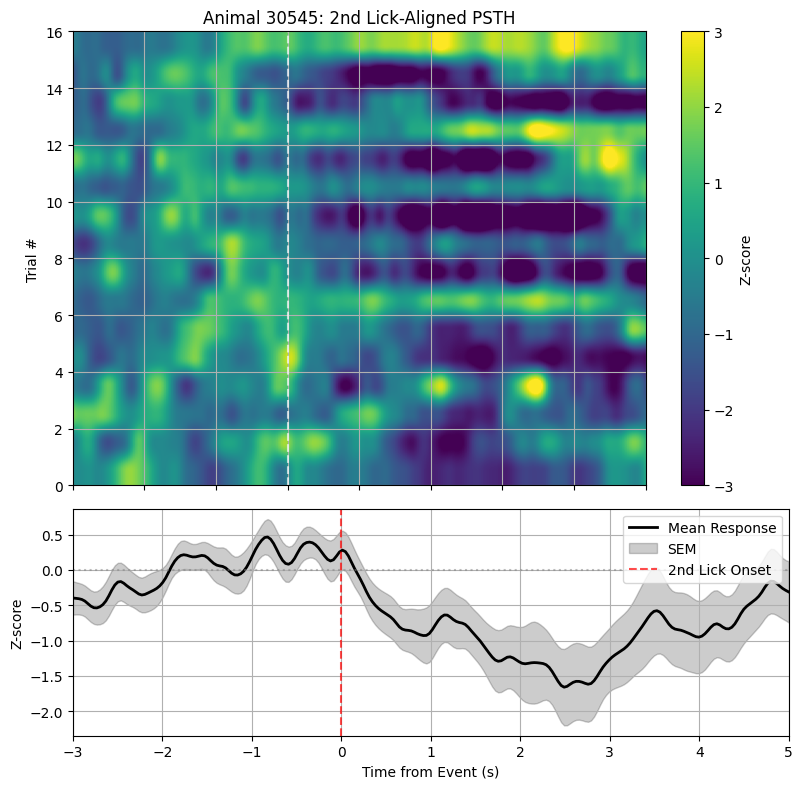

Animal 30546: Found 13 valid events (2nd lick of burst).


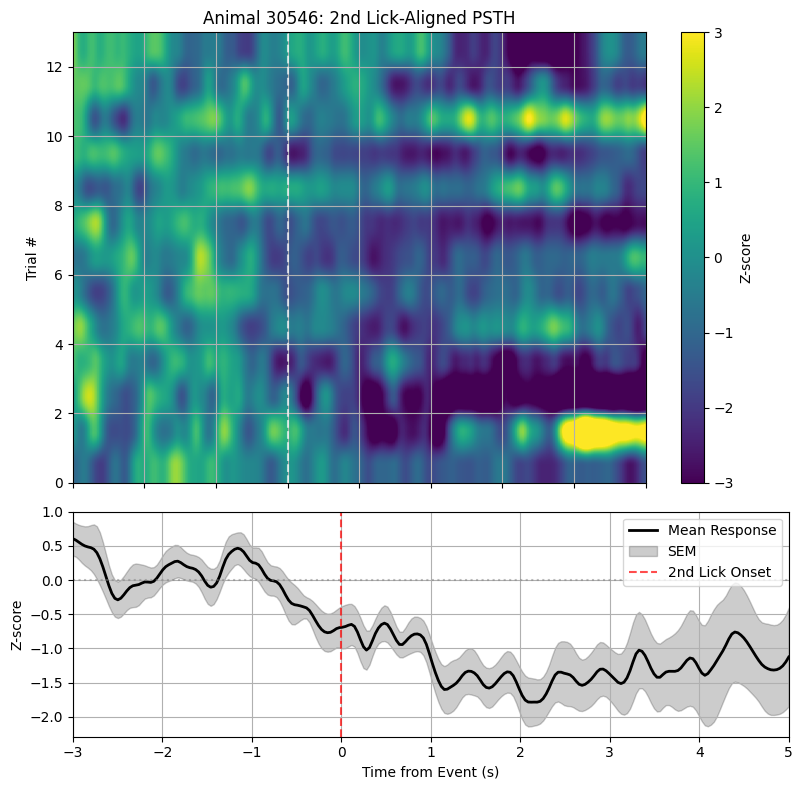

Animal 30547: Found 12 valid events (2nd lick of burst).


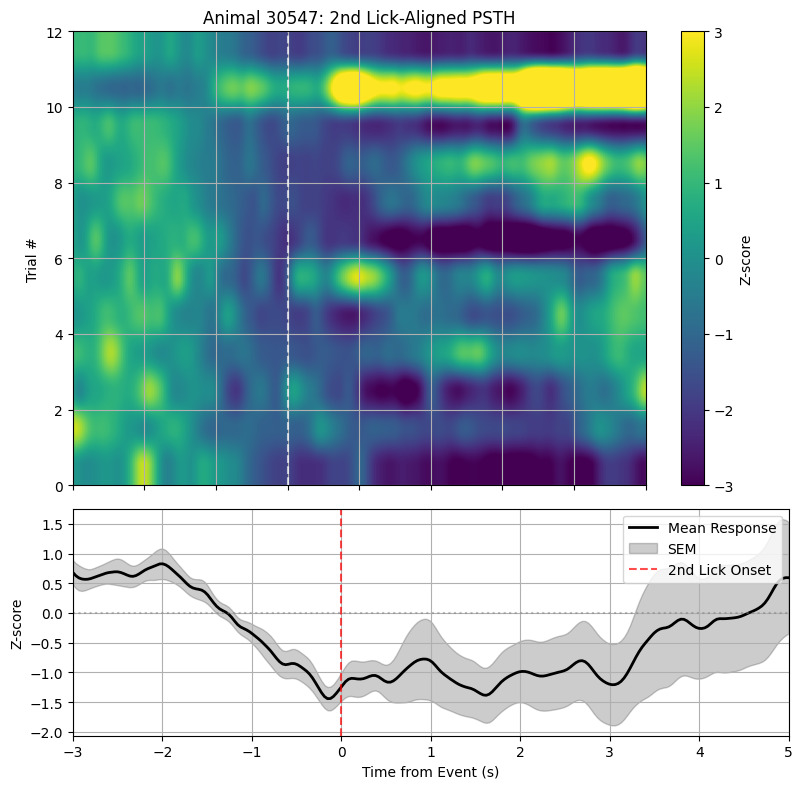

Animal 30549: Found 13 valid events (2nd lick of burst).


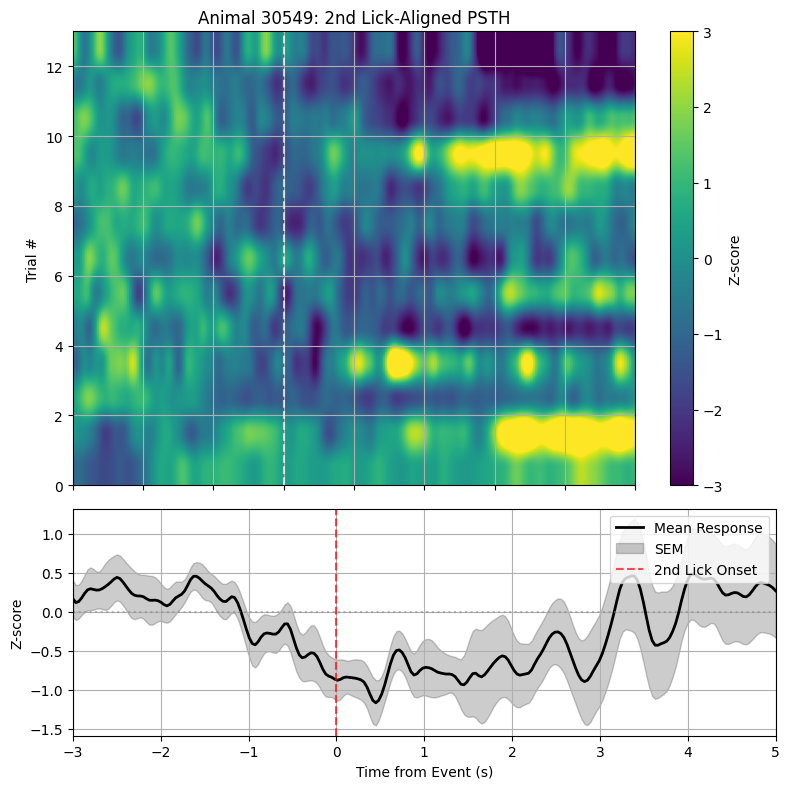


Processing Complete.
PSTH data saved in 'psth_results' for 4 animals.


In [8]:
# ---- NEW: Dictionary to store results for later usage ----
psth_results = {}

for animal_id, metrics in per_animal.items():
    # 1. Get raw data from original results
    if animal_id not in results:
        continue

    raw_data = results[animal_id]
    t = raw_data["t"]
    dff = raw_data["dff"]

    # 2. Extract Events (2nd lick of burst)
    events = metrics["lick_onset"]
    events = events[~np.isnan(events)] # Remove NaNs

    print(f"Animal {animal_id}: Found {len(events)} valid events (2nd lick of burst).")

    if len(events) < 5:
        print(f"  -> Skipping (Not enough trials)")
        continue

    # 3. Compute PSTH
    tvec, mat = compute_psth_matrix(
        t, dff, events,
        window=(-3, 5),          # 3s before to 5s after
        baseline_win=(-3, 0),    # Baseline: -3s to 0s
        smooth_sigma_s=0
    )

    # Remove rows that stayed NaN (boundary issues)
    mat = mat[~np.isnan(mat).all(axis=1)]

    if len(mat) == 0:
        continue

    # ---- SAVE TO DICTIONARY ----
    psth_results[animal_id] = {
        "time_vector": tvec,
        "psth_matrix": mat,
        "mean_trace": np.nanmean(mat, axis=0),
        "sem_trace": np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0]),
        "n_trials": mat.shape[0]
    }

    # 4. Plot (Optional - can be commented out if you just want to save)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})

    # A. Heatmap
    im = ax1.imshow(mat, aspect='auto', origin='lower',
                    extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
                    cmap='viridis', vmin=-3, vmax=3)

    ax1.set_ylabel("Trial #")
    ax1.set_title(f"Animal {animal_id}: 2nd Lick-Aligned PSTH")
    plt.colorbar(im, ax=ax1, label="Z-score")
    ax1.axvline(0, color='w', linestyle='--', alpha=0.7)

    # B. Average Response
    mean_trace = psth_results[animal_id]["mean_trace"]
    sem_trace = psth_results[animal_id]["sem_trace"]

    ax2.plot(tvec, mean_trace, color='k', lw=2, label="Mean Response")
    ax2.fill_between(tvec, mean_trace - sem_trace, mean_trace + sem_trace,
                     color='k', alpha=0.2, label="SEM")

    ax2.axvline(0, color='r', linestyle='--', alpha=0.7, label="2nd Lick Onset")
    ax2.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel("Time from Event (s)")
    ax2.set_ylabel("Z-score")
    ax2.set_xlim(tvec[0], tvec[-1])
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

print("\nProcessing Complete.")
print(f"PSTH data saved in 'psth_results' for {len(psth_results)} animals.")
# Usage example: psth_results['Animal_01']['psth_matrix']


Analyzing correlation between Lick Count and PSTH AUC (0s to 4s)...


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4266876\3982890815.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_values = np.trapz(mat[:, idx_start:idx_end], dx=1/common_fs, axis=1)


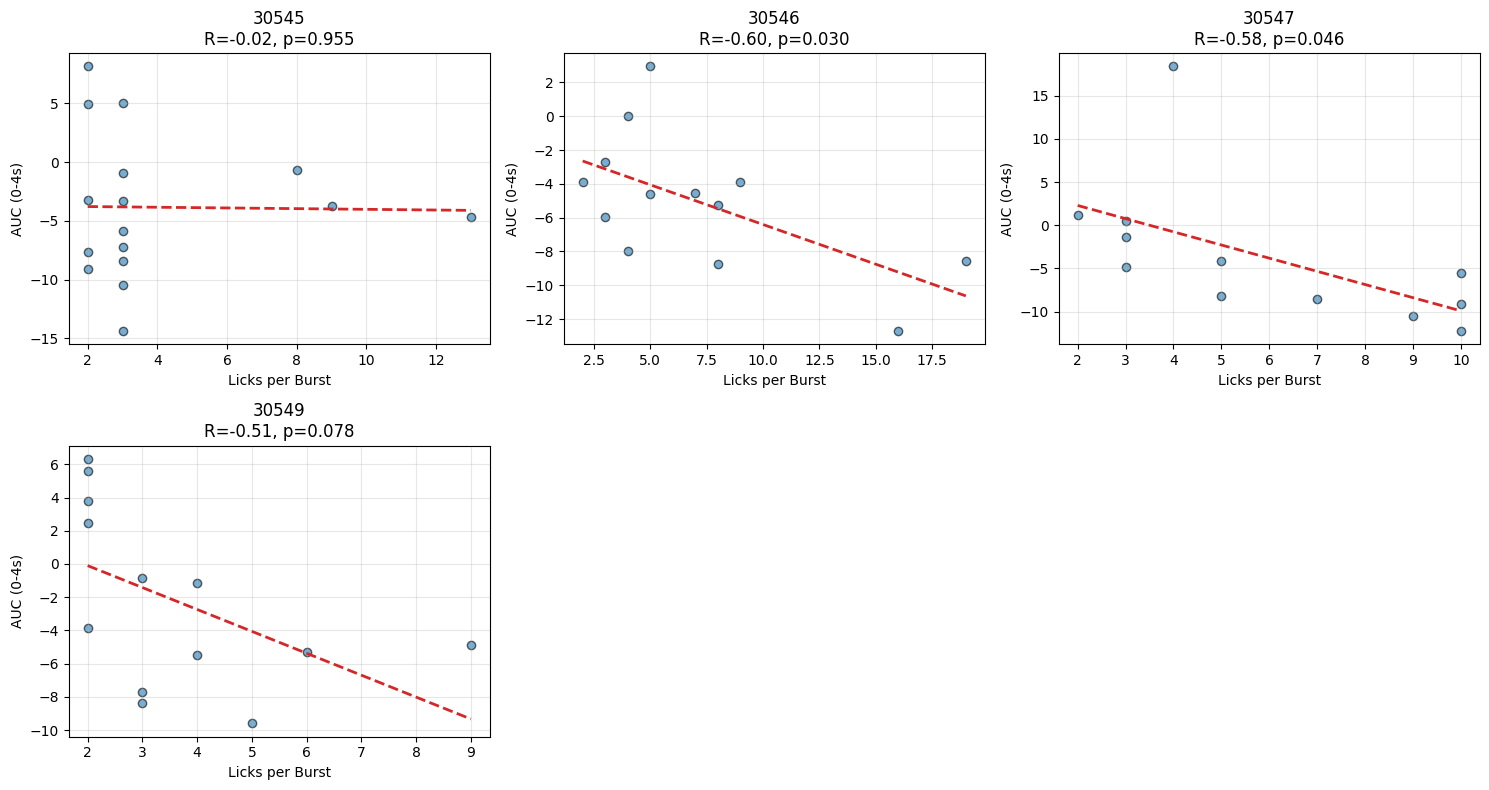

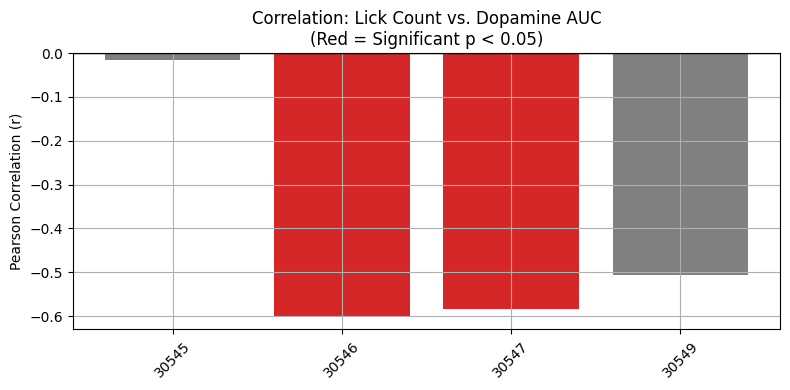

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# Settings
AUC_WINDOW = (0, 4)  # Window for AUC calculation (seconds)
common_fs = 1.0 / np.nanmedian(np.diff(psth_results[list(psth_results.keys())[0]]["time_vector"]))

print(f"Analyzing correlation between Lick Count and PSTH AUC ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

# Store correlation results for summary
correlation_summary = {}

# Setup Plotting Grid (dynamic based on n_animals)
n_animals = len(psth_results)
n_cols = 3
n_rows = int(np.ceil(n_animals / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, animal_id in enumerate(sorted(psth_results.keys())):
    ax = axes[i]

    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # Retrieve trial-by-trial lick counts (burst sizes) from the metrics dict
    # Note: We must ensure alignment. The PSTH matrix rows correspond to the valid events in 'lick_onset'.
    # In the previous script, we filtered 'lick_onset' for NaNs. We must apply the same filter to 'burst_sizes'.
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]

    # Filter: Keep only trials that were valid for PSTH (i.e., had a valid 2nd lick)
    valid_mask = ~np.isnan(raw_lick_onsets)
    trial_lick_counts = raw_burst_sizes[valid_mask]

    # Double Check Alignment: Matrix rows vs Lick Count length
    # If PSTH matrix dropped rows due to boundary issues (edges of recording), we must truncate the lick counts too.
    # The previous script did: mat = mat[~np.isnan(mat).all(axis=1)]
    # We need to assume the 'mat' in psth_results corresponds to the *start* of the valid list.
    # If rows were dropped from the *end* or *middle* blindly, alignment is lost.
    # Ideally, we would have stored the 'valid_indices' in psth_results.
    # FORCE ALIGNMENT: Truncate to the shorter length (assuming chronological drop from ends if any)
    n_trials = min(len(trial_lick_counts), mat.shape[0])
    trial_lick_counts = trial_lick_counts[:n_trials]
    mat = mat[:n_trials, :]

    # 2. Calculate AUC for each trial
    # Find indices for the AUC window
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Extract window and compute AUC (Trapezoidal rule)
    # axis=1 integrates along time
    auc_values = np.trapz(mat[:, idx_start:idx_end], dx=1/common_fs, axis=1)

    # 3. Correlation
    r_val, p_val = pearsonr(trial_lick_counts, auc_values)
    correlation_summary[animal_id] = (r_val, p_val)

    # 4. Plot
    # Scatter points
    ax.scatter(trial_lick_counts, auc_values, alpha=0.6, color='tab:blue', edgecolor='k')

    # Linear Regression Line
    m, b = np.polyfit(trial_lick_counts, auc_values, 1)
    x_fit = np.array([trial_lick_counts.min(), trial_lick_counts.max()])
    ax.plot(x_fit, m*x_fit + b, color='tab:red', linestyle='--', lw=2, label=f"Fit")

    # Styling
    ax.set_title(f"{animal_id}\nR={r_val:.2f}, p={p_val:.3f}")
    ax.set_xlabel("Licks per Burst")
    ax.set_ylabel(f"AUC ({AUC_WINDOW[0]}-{AUC_WINDOW[1]}s)")
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# --- Summary Plot of Correlations ---
plt.figure(figsize=(8, 4))
r_values = [v[0] for v in correlation_summary.values()]
ids = list(correlation_summary.keys())
colors = ['tab:red' if v[1] < 0.05 else 'gray' for v in correlation_summary.values()]

plt.bar(ids, r_values, color=colors)
plt.axhline(0, color='k', linewidth=1)
plt.ylabel("Pearson Correlation (r)")
plt.title("Correlation: Lick Count vs. Dopamine AUC\n(Red = Significant p < 0.05)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Aggregating data for Global Correlation (-5s to 5s)...
Total Trials Analyzed: 54


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4266876\2968546013.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_values = np.trapz(mat_aligned[:, idx_start:idx_end], dx=1/fs, axis=1)


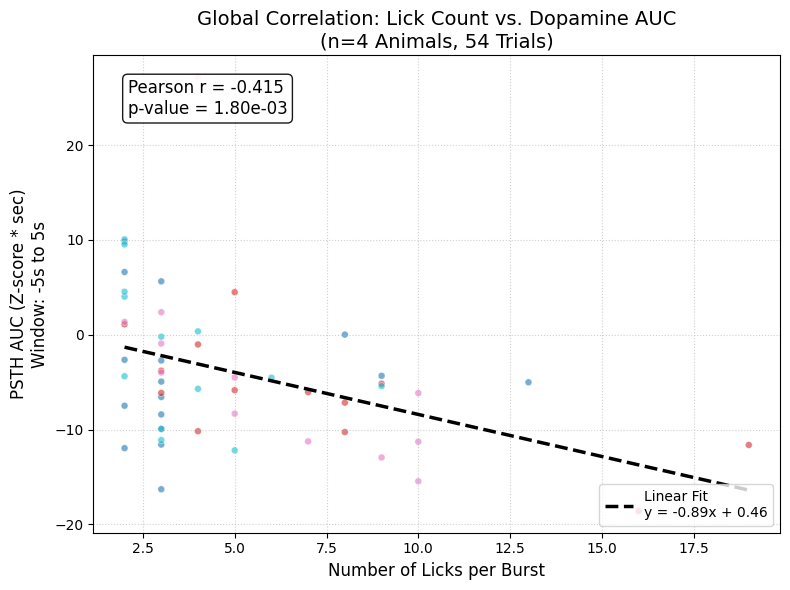

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Global Correlation Analysis: Pooled Data (All Animals)
# =============================================================================

# Settings
AUC_WINDOW = (-5, 5)  # Window for AUC calculation (seconds)

# Containers for pooled data
all_lick_counts = []
all_auc_values = []
animal_colors = [] # Optional: to color-code points by animal

# Setup colormap for distinguishing animals in the scatter
cmap = plt.get_cmap('tab10')
animal_ids = sorted(psth_results.keys())

print(f"Aggregating data for Global Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for i, animal_id in enumerate(animal_ids):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # Estimate sampling rate from time vector
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # 2. Retrieve & Filter Behavioral Data
    # Get raw arrays
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]

    # Apply the same filter used to generate the PSTH events:
    # Keep only bursts that had a valid "2nd lick" timestamp (i.e., not NaN)
    valid_behavior_mask = ~np.isnan(raw_lick_onsets)
    trial_lick_counts = raw_burst_sizes[valid_behavior_mask]

    # 3. Align Behavioral Data with PSTH Matrix
    # The PSTH matrix might be shorter if trials at the very end of the recording
    # were dropped due to window boundaries.
    n_psth_trials = mat.shape[0]
    n_behavior_trials = len(trial_lick_counts)

    # We assume chronological order, so we truncate the longer array to match the shorter one.
    n_valid = min(n_psth_trials, n_behavior_trials)

    # Truncate
    trial_lick_counts = trial_lick_counts[:n_valid]
    mat_aligned = mat[:n_valid, :]

    # 4. Calculate AUC for valid trials
    # Find indices for the integration window
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC using Trapezoidal rule along axis 1 (time)
    auc_values = np.trapz(mat_aligned[:, idx_start:idx_end], dx=1/fs, axis=1)

    # 5. Append to Global Lists
    all_lick_counts.extend(trial_lick_counts)
    all_auc_values.extend(auc_values)

    # Store color index for this batch of points
    animal_colors.extend([i] * n_valid)

# Convert to numpy arrays for analysis
all_lick_counts = np.array(all_lick_counts)
all_auc_values = np.array(all_auc_values)
animal_colors = np.array(animal_colors)

print(f"Total Trials Analyzed: {len(all_lick_counts)}")

# =============================================================================
# Statistical Analysis & Plotting
# =============================================================================

if len(all_lick_counts) > 5:
    # 1. Pearson Correlation
    r_val, p_val = pearsonr(all_lick_counts, all_auc_values)

    # 2. Linear Regression (for the fit line)
    slope, intercept, _, _, _ = linregress(all_lick_counts, all_auc_values)

    # 3. Plotting
    plt.figure(figsize=(8, 6))

    # Scatter Plot (Color-coded by animal)
    scatter = plt.scatter(all_lick_counts, all_auc_values,
                          c=animal_colors, cmap='tab10',
                          alpha=0.6, s=25, edgecolor='w', linewidth=0.5)

    # Regression Line
    x_range = np.linspace(all_lick_counts.min(), all_lick_counts.max(), 100)
    y_fit = slope * x_range + intercept

    plt.plot(x_range, y_fit, color='black', linestyle='--', linewidth=2.5,
             label=f"Linear Fit\ny = {slope:.2f}x + {intercept:.2f}")

    # Aesthetics
    plt.title(f"Global Correlation: Lick Count vs. Dopamine AUC\n(n={len(animal_ids)} Animals, {len(all_lick_counts)} Trials)", fontsize=14)
    plt.xlabel("Number of Licks per Burst", fontsize=12)
    plt.ylabel(f"PSTH AUC (Z-score * sec)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)

    # Legend for Statistics
    stats_text = f"Pearson r = {r_val:.3f}\np-value = {p_val:.2e}"
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Optional: Create a custom legend for animals
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), label=aid) for i, aid in enumerate(animal_ids)]
    # plt.legend(handles=handles, title="Animal ID", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for correlation analysis.")


Computing per-animal averages for Correlation (-1s to 4s)...


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4266876\419417745.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  animal_auc = np.trapz(mean_trace[idx_start:idx_end], dx=1/fs)


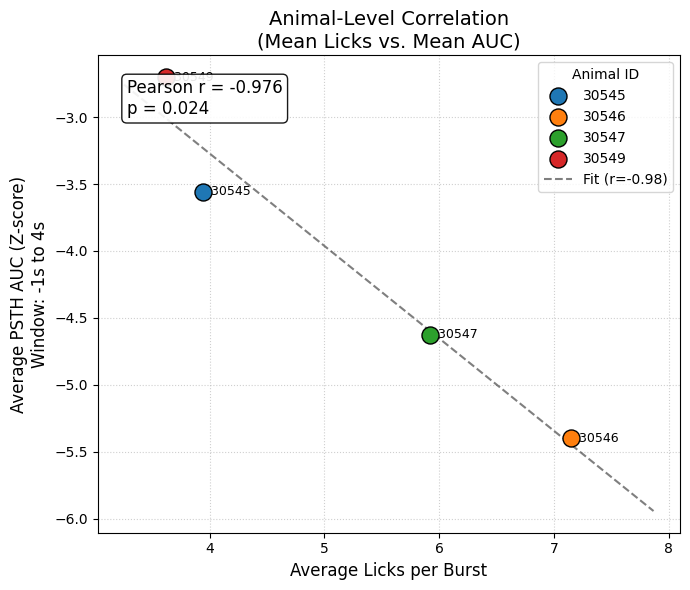


--- Summary Data ---
30545: 3.94 licks/burst | -3.56 AUC
30546: 7.15 licks/burst | -5.40 AUC
30547: 5.92 licks/burst | -4.63 AUC
30549: 3.62 licks/burst | -2.70 AUC


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Animal-Level Correlation: Mean Licks vs. Mean AUC
# =============================================================================

# Settings
AUC_WINDOW = (-1, 4)  # Window for AUC calculation (seconds)

# Containers for animal-level means
mean_licks_per_animal = []
mean_auc_per_animal = []
animal_ids_list = []

print(f"Computing per-animal averages for Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for animal_id in sorted(psth_results.keys()):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # 2. Compute Mean AUC for this animal
    # Method: Calculate AUC for the *average trace* (more robust to noise)
    # Alternatively, you could calc AUC per trial then mean, but for Z-scores, linear operations are commutative.

    # Calculate Mean Trace first
    mean_trace = np.nanmean(mat, axis=0)

    # Estimate sampling rate
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # Find indices for integration
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC of the mean trace
    animal_auc = np.trapz(mean_trace[idx_start:idx_end], dx=1/fs)

    # 3. Compute Mean Licks for this animal
    # Retrieve raw burst sizes
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]

    # Filter for valid bursts only (same filter as PSTH events)
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]
    valid_mask = ~np.isnan(raw_lick_onsets)
    valid_burst_sizes = raw_burst_sizes[valid_mask]

    # Calculate mean lick count
    if len(valid_burst_sizes) > 0:
        animal_mean_licks = np.mean(valid_burst_sizes)
    else:
        print(f"Warning: No valid bursts for {animal_id}")
        continue

    # 4. Store Data
    mean_licks_per_animal.append(animal_mean_licks)
    mean_auc_per_animal.append(animal_auc)
    animal_ids_list.append(animal_id)

# Convert to numpy arrays
x_vals = np.array(mean_licks_per_animal)
y_vals = np.array(mean_auc_per_animal)

# =============================================================================
# Plotting & Statistics
# =============================================================================

plt.figure(figsize=(7, 6))

if len(x_vals) > 1:
    # 1. Linear Regression
    slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)

    # 2. Plot Points
    # Use a distinct color/marker for each animal
    for i, aid in enumerate(animal_ids_list):
        plt.scatter(x_vals[i], y_vals[i], s=150, zorder=3, label=aid, edgecolor='k')
        # Annotate ID next to dot
        plt.text(x_vals[i], y_vals[i], f"  {aid}", verticalalignment='center', fontsize=9)

    # 3. Plot Fit Line
    x_range = np.array([x_vals.min() * 0.9, x_vals.max() * 1.1])
    plt.plot(x_range, slope * x_range + intercept, 'k--', alpha=0.5, zorder=2,
             label=f"Fit (r={r_val:.2f})")

    # 4. Stats Text
    stats_msg = f"Pearson r = {r_val:.3f}\np = {p_val:.3f}"
    plt.text(0.05, 0.95, stats_msg, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

else:
    plt.scatter(x_vals, y_vals, s=100)
    print("Not enough points for regression.")

# Aesthetics
plt.title("Animal-Level Correlation\n(Mean Licks vs. Mean AUC)", fontsize=14)
plt.xlabel("Average Licks per Burst", fontsize=12)
plt.ylabel(f"Average PSTH AUC (Z-score)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Animal ID")
plt.tight_layout()
plt.show()

# Print Data for verification
print("\n--- Summary Data ---")
for aid, licks, auc in zip(animal_ids_list, x_vals, y_vals):
    print(f"{aid}: {licks:.2f} licks/burst | {auc:.2f} AUC")


Aggregating pre-computed per-animal averages...
Averaging across 4 animals.


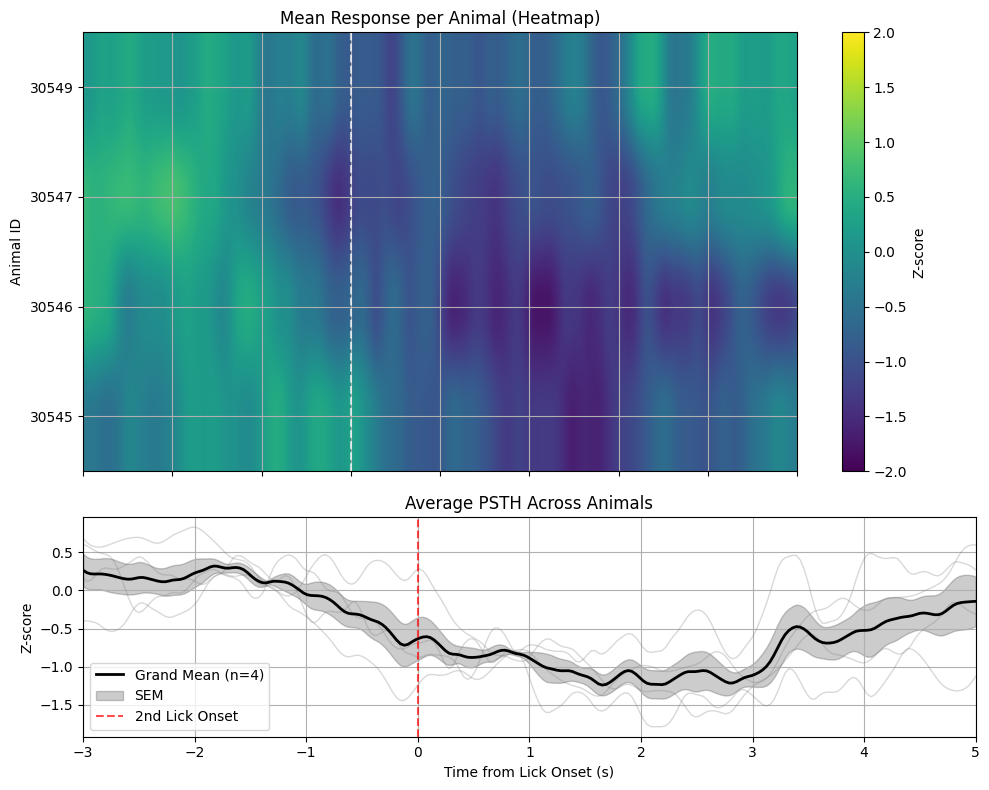

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Aggregation and Plotting using Pre-Computed 'psth_results'
# =============================================================================

# Container for animal averages
animal_mean_traces = []
animal_ids_list = []
common_tvec = None

print("Aggregating pre-computed per-animal averages...")

# Ensure psth_results exists
if 'psth_results' not in locals():
    print("Error: 'psth_results' dictionary not found. Please run the PSTH computation script first.")
else:
    for animal_id, data in psth_results.items():
        # 1. Retrieve Pre-computed Mean Trace
        mean_trace = data.get("mean_trace")
        tvec = data.get("time_vector")

        if mean_trace is None or tvec is None:
            print(f"  Warning: Missing data for {animal_id}, skipping.")
            continue

        # 2. Check for length consistency
        # Initialize common_tvec with the first valid animal
        if common_tvec is None:
            common_tvec = tvec
            expected_length = len(tvec)

        # Ensure alignment (simple length check)
        if len(mean_trace) != expected_length:
            print(f"  Warning: Length mismatch for {animal_id} ({len(mean_trace)} vs {expected_length}). Skipping.")
            continue

        # 3. Store
        animal_mean_traces.append(mean_trace)
        animal_ids_list.append(animal_id)

    # --- Plotting ---

    if len(animal_mean_traces) > 0:
        # Stack into matrix: (n_animals x n_timepoints)
        grand_matrix = np.vstack(animal_mean_traces)
        n_animals = grand_matrix.shape[0]

        # Compute Grand Average and SEM across animals
        grand_mean = np.nanmean(grand_matrix, axis=0)
        grand_sem = np.nanstd(grand_matrix, axis=0) / np.sqrt(n_animals)

        print(f"Averaging across {n_animals} animals.")

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # --- Subplot 1: Heatmap (Each line is an animal) ---
        # Extent controls the axis values: [x_min, x_max, y_min, y_max]
        # We set y to range from -0.5 to n_animals-0.5 so ticks align with integers
        im = ax1.imshow(grand_matrix, aspect='auto', origin='lower',
                        extent=[common_tvec[0], common_tvec[-1], -0.5, n_animals - 0.5],
                        cmap='viridis', vmin=-2, vmax=2) # Adjust vmin/vmax for Z-score visibility

        ax1.set_yticks(range(n_animals))
        ax1.set_yticklabels(animal_ids_list)
        ax1.set_ylabel("Animal ID")
        ax1.set_title("Mean Response per Animal (Heatmap)")
        ax1.axvline(0, color='w', linestyle='--', alpha=0.7)
        plt.colorbar(im, ax=ax1, label="Z-score")

        # --- Subplot 2: Grand Average Trace ---
        # Plot individual animal traces (faint lines)
        for i in range(n_animals):
            ax2.plot(common_tvec, grand_matrix[i, :], color='gray', alpha=0.3, lw=1)

        # Plot Grand Mean + SEM
        ax2.plot(common_tvec, grand_mean, color='k', lw=2, label=f"Grand Mean (n={n_animals})")
        ax2.fill_between(common_tvec, grand_mean - grand_sem, grand_mean + grand_sem,
                        color='k', alpha=0.2, label="SEM")

        ax2.axvline(0, color='r', linestyle='--', alpha=0.7, label="2nd Lick Onset")
        ax2.set_xlabel("Time from Lick Onset (s)")
        ax2.set_ylabel("Z-score")
        ax2.set_title("Average PSTH Across Animals")
        ax2.set_xlim(common_tvec[0], common_tvec[-1])
        ax2.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("No valid data to average.")
